In [38]:
import numpy as np
import scipy.io
import scipy.integrate
import pylab
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import psd_multitaper
 
%matplotlib inline

mne.set_log_level('WARNING')

## Set Parameters

In [368]:
freq_s = 250    # [Hz] Sampling Frequency
trial_len = 4    # [sec] Length of a single trial
n_channels = 3    # set numpy of channels to use from raw eeg matrix
alpha_range = [8, 14]    # [Hz] range of alpha frequency
alpha_subbands_frq = np.array([np.arange(8,12),np.arange(10,14)]).T.astype(float)    # Sub bands of alpha
print('Alpha frequency range: {}\nAlpha sub bands:\n{}'.format(alpha_range, alpha_subbands_frq))

Alpha frequency range: [8, 14]
Alpha sub bands:
[[  8.  10.]
 [  9.  11.]
 [ 10.  12.]
 [ 11.  13.]]


## Read raw eeg data

In [40]:
# Load Raw EEG
raw_fname = '/Users/leonardrychly/Dropbox/[TUM]/4. WiSe 1617/Masterarbeit/Code/eeg_feature_extraction/exp_1-raw.fif'
raw = mne.io.read_raw_fif(raw_fname, add_eeg_ref=False).load_data()

# Remove EOG channels (channels 4-6)
raw.drop_channels(['eog_4','eog_5', 'eog_6'])

<Raw  |  exp_1-raw.fif, n_channels x n_times : 3 x 552452 (2209.8 sec), ~12.7 MB, data loaded>

## Remove trials with artifacts from 'trials' and 'y' corresponding to the raw eeg data

In [41]:
# Load data containing artifacts
data_path = "/Users/leonardrychly/Dropbox/[TUM]/4. WiSe 1617/Masterarbeit/Code/eeg_feature_extraction/B01T.mat"
mat = scipy.io.loadmat(data_path)['data']

# Get artifacts
exp_arr = mat[0,0]
# explanation:   exp_arr[0][0][data]
exp_dict = {'X': exp_arr[0][0][0].T,
            'trial': exp_arr[0][0][1],
            'y': exp_arr[0][0][2],
            'fs': exp_arr[0][0][3].flatten(),
             'classes': exp_arr[0][0][4].flatten(),
             'artifacts': exp_arr[0][0][5],
             'gender': exp_arr[0][0][6],
             'age': exp_arr[0][0][7].flatten()
             }

# Remove from 'trials' and 'y'
artifact_idx = exp_dict['artifacts'].nonzero()[0]
exp_dict['trial'] = np.delete(exp_dict['trial'], artifact_idx)
exp_dict['y'] = np.delete(exp_dict['y'], artifact_idx)

## Plot  part of  EEG raw

In [42]:
# Plot window
start = exp_dict['trial'][0]
stop = start + (trial_len * freq_s)

# Calulate start and stop time from start/stop sample index 
t_start = start / freq_s
t_stop = (start + (trial_len * freq_s)) / freq_s

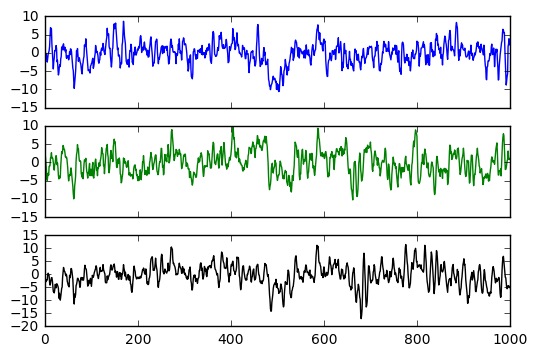

In [43]:
# Plot a segment of raw data
raw_segment, times = raw[:, start:stop]

f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(np.arange(len(raw_segment[0])), raw_segment[0], c='blue')
ax1.plot(np.arange(len(raw_segment[1])), raw_segment[1], c='green')
ax2.plot(np.arange(len(raw_segment[2])), raw_segment[2], c='black')

## Filter alpha band

In [44]:
raw_temp = raw.copy()    #  make copy of raw to band pass filter and keep original

raw_alpha = raw_temp.filter(l_freq=alpha_range[0], h_freq=alpha_range[1], 
                            filter_length='auto', l_trans_bandwidth='auto', 
                            h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                            iir_params=None, phase='zero', fir_window='hamming')

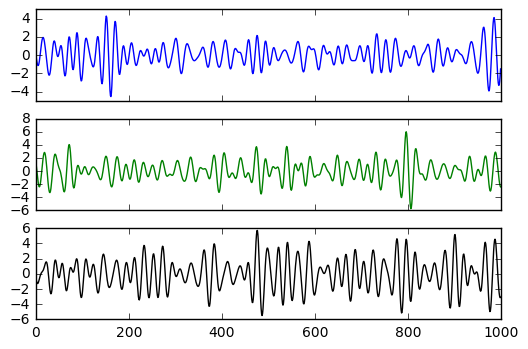

In [45]:
# Plot
raw_segment, times = raw_alpha[:, start:stop]

f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(np.arange(len(raw_segment[0])), raw_segment[0], c='blue')
ax1.plot(np.arange(len(raw_segment[1])), raw_segment[1], c='green')
ax2.plot(np.arange(len(raw_segment[2])), raw_segment[2], c='black')

## Filter into subbands

#### Filter RAW

In [80]:
raw_alpha_sub_list = [[] for _ in range(len(alpha_subbands_frq))]
for sb_idx, subband in enumerate(alpha_subbands_frq):
    raw_temp = raw_alpha.copy()
    raw_alpha_sub_list[sb_idx] = raw_temp.filter(l_freq=subband[0], h_freq=subband[1], 
                                                 filter_length='auto', l_trans_bandwidth='auto', 
                                                 h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                                                 iir_params=None, phase='zero', fir_window='hamming')

In [81]:
# Plot
raw_sub_segment_0, times = raw_alpha_sub_list[0][:, start:stop]
raw_sub_segment_1, times = raw_alpha_sub_list[1][:, start:stop]
raw_sub_segment_2, times = raw_alpha_sub_list[2][:, start:stop]
raw_sub_segment_3, times = raw_alpha_sub_list[3][:, start:stop]
raw_sub_segment_4, times = raw_alpha_sub_list[4][:, start:stop]

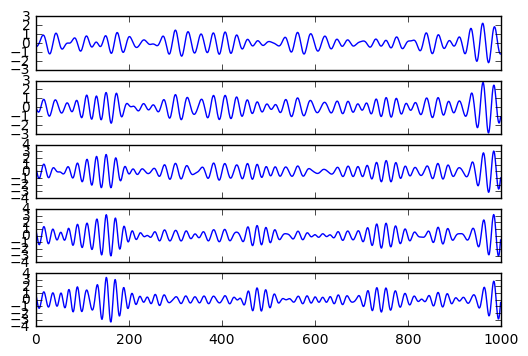

In [91]:
# Sub bands of channel 1
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[0])), raw_sub_segment_0[0], c='blue')
ax1.plot(np.arange(len(raw_sub_segment_1[0])), raw_sub_segment_1[0], c='blue')
ax2.plot(np.arange(len(raw_sub_segment_2[0])), raw_sub_segment_2[0], c='blue')
ax3.plot(np.arange(len(raw_sub_segment_3[0])), raw_sub_segment_3[0], c='blue')
ax4.plot(np.arange(len(raw_sub_segment_4[0])), raw_sub_segment_4[0], c='blue')

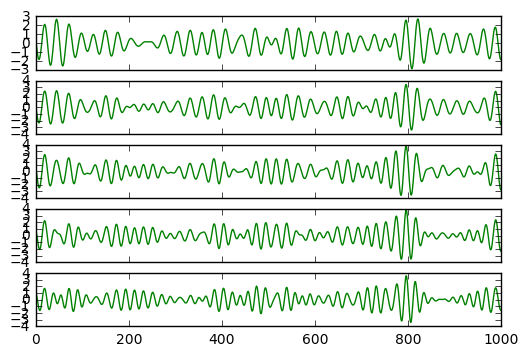

In [84]:
# Sub bands of channel 2
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[1])), raw_sub_segment_0[1], c='green')
ax1.plot(np.arange(len(raw_sub_segment_1[1])), raw_sub_segment_1[1], c='green')
ax2.plot(np.arange(len(raw_sub_segment_2[1])), raw_sub_segment_2[1], c='green')
ax3.plot(np.arange(len(raw_sub_segment_3[1])), raw_sub_segment_3[1], c='green')
ax4.plot(np.arange(len(raw_sub_segment_4[1])), raw_sub_segment_4[1], c='green')

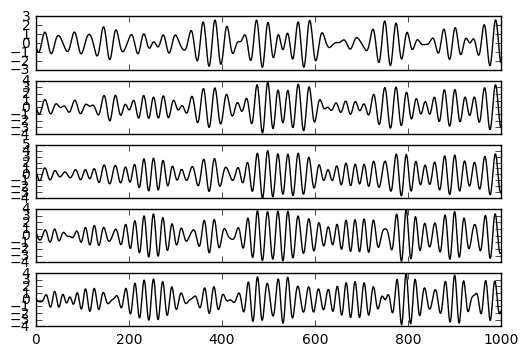

In [92]:
# Sub bands of channel 3
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[2])), raw_sub_segment_0[2], c='black')
ax1.plot(np.arange(len(raw_sub_segment_1[2])), raw_sub_segment_1[2], c='black')
ax2.plot(np.arange(len(raw_sub_segment_2[2])), raw_sub_segment_2[2], c='black')
ax3.plot(np.arange(len(raw_sub_segment_3[2])), raw_sub_segment_3[2], c='black')
ax4.plot(np.arange(len(raw_sub_segment_4[2])), raw_sub_segment_4[2], c='black')

## Calculate Power Spectral Density

### Plot PSD

In [161]:
# Set time range to clacualte PSD
print('t_start:' , t_start)
print('t_stop:', t_stop)

t_start: 220.56
t_stop: 224.56


In [340]:
# PSD: Alpha sub band 1 (8-10Hz)
#p = raw_alpha_sub_list[0].plot_psd(tmin=t_start, tmax=t_stop, 
#                                   fmin=alpha_range[0], fmax=alpha_range[1], 
#                                   color=(0.5, 0.1, 1))

In [341]:
# PSD: Alpha sub band 2 (9-11Hz)
#p = raw_alpha_sub_list[1].plot_psd(tmin=t_start, tmax=t_stop, 
#                                   fmin=alpha_range[0], fmax=alpha_range[1], 
#                                   color=(0.5, 0.1, 1))

In [342]:
# PSD: Alpha sub band 3 (10-12Hz)
#p = raw_alpha_sub_list[2].plot_psd(tmin=t_start, tmax=t_stop, 
#                                   fmin=alpha_range[0], fmax=alpha_range[1], 
#                                   color=(0.5, 0.1, 1))

In [343]:
# PSD: Alpha sub band 4 (11-13Hz)
#p = raw_alpha_sub_list[3].plot_psd(tmin=t_start, tmax=t_stop, 
#                                   fmin=alpha_range[0], fmax=alpha_range[1], 
#                                   color=(0.5, 0.1, 1))

In [344]:
# PSD: Alpha sub band 5 (12-14Hz)
#p = raw_alpha_sub_list[4].plot_psd(tmin=t_start, tmax=t_stop, 
#                                   fmin=alpha_range[0], fmax=alpha_range[1], 
#                                   color=(0.5, 0.1, 1))

### Calculate PSD (approximate with Multitaper)

#### psds, freqs = psd_multitaper():
* psds : ndarray, shape (..., n_freqs)

The power spectral densities. If input is of type Raw, then psds will be shape (n_channels, n_freqs), if input is type Epochs then psds will be shape (n_epochs, n_channels, n_freqs).
* freqs : ndarray, shape (n_freqs,)

The frequencies.

In [330]:
# Approximate PSD for one alpha sub band TRIAL
f_min, f_max = 5, 14
psds_trial, freqs_trial = psd_multitaper(raw_alpha_sub_list[0], low_bias=True, tmin=t_start, tmax=t_stop,
                                         fmin=f_min, fmax=f_max, proj=True)

In [331]:
# PSD for prior to the one alpha sub band REST
delta_t_prior = 2    # sec
psds_rest, freqs_rest = psd_multitaper(raw_alpha_sub_list[0], low_bias=True, 
                                         tmin=t_start-delta_t_prior, tmax=t_start,
                                         fmin=f_min, fmax=f_max, proj=True)

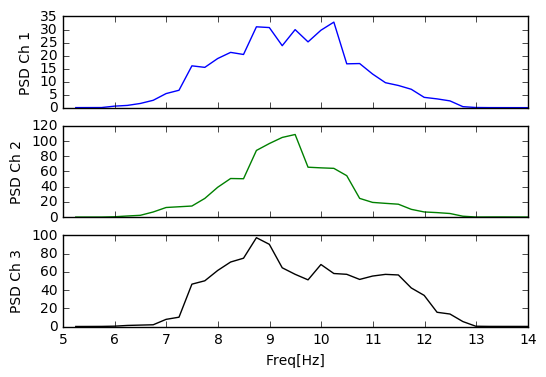

In [332]:
# Plot PSD for each Channel (of sub band 1) TRIAL
f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(freqs_trial, psds_trial[0], c='blue')
ax0.set_ylabel("PSD Ch 1")
ax1.plot(freqs_trial, psds_trial[1], c='green')
ax1.set_ylabel("PSD Ch 2")
ax2.plot(freqs_trial, psds_trial[2], c='black')
ax2.set_xlabel("Freq[Hz]")
ax2.set_ylabel("PSD Ch 3")

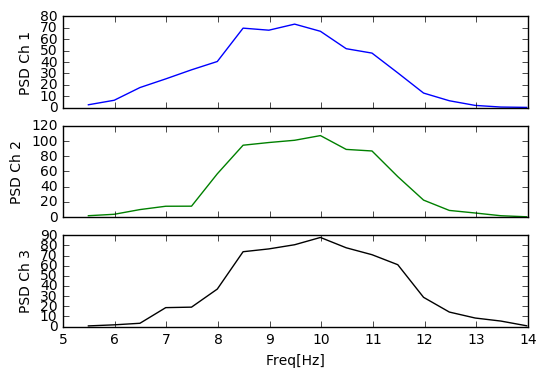

In [333]:
# Plot PSD for each Channel (of sub band 1) REST
f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(freqs_rest, psds_rest[0], c='blue')
ax0.set_ylabel("PSD Ch 1")
ax1.plot(freqs_rest, psds_rest[1], c='green')
ax1.set_ylabel("PSD Ch 2")
ax2.plot(freqs_rest, psds_rest[2], c='black')
ax2.set_xlabel("Freq[Hz]")
ax2.set_ylabel("PSD Ch 3")

## Calulate Power

In [326]:
# Calc power for each channel in alpha sub band 1 TRIAL
powers_trial = []
for psd in psds_trial:
    powers_trial.append(scipy.integrate.simps(psd))
# Alpha sub band 1, channel 1,2,3
powers_trial

[395.86160961216052, 972.44282487350722, 1202.8945032976992]

In [334]:
# Calc power for each channel in alpha sub band 1 REST
powers_rest = []
for psd in psds_prior:
    powers_rest.append(scipy.integrate.simps(psd))
# Alpha sub band 1, channel 1,2,3
powers_rest

[554.64015769863011, 769.29894421067297, 666.00938453826438]

In [335]:
# Difference between trial and Prior
np.array(powers_trial) - np.array(powers_rest)

array([-158.77854809,  203.14388066,  536.88511876])

## Function to calculate power of subbands for one interval

In [348]:
freq_s = 250    # Hz
trial_len = 1.5   # sec
rest_len = 2    # sec

# TRIAL: sample idx start/stop 
trial_idx_start = exp_dict['trial'][0]
trial_idx_stop = start + (trial_len * freq_s)
# time points start/stop 
trial_t_start = trial_idx_start / freq_s
trial_t_stop = (trial_idx_start + (trial_len * freq_s)) / freq_s

# REST: sample idx start/stop 
rest_idx_stop = trial_idx_start
rest_idx_start = trial_idx_start - (rest_len * freq_s)
# time points start/stop
rest_t_stop = rest_idx_stop / freq_s
rest_t_start = rest_idx_start / freq_s

print('Trial - idx_start={}, idx_stop={}, t_start={}, t_stop={}'.format(
        trial_idx_start, trial_idx_stop, trial_t_start, trial_t_stop))
print('Rest - idx_start={}, idx_stop={}, t_start={}, t_stop={}'.format(
        rest_idx_start, rest_idx_stop, rest_t_start, rest_t_stop))

Trial - idx_start=55140, idx_stop=56140, t_start=220.56, t_stop=224.56
Rest - idx_start=54640, idx_stop=55140, t_start=218.56, t_stop=220.56


In [366]:
dt_rest = [rest_t_start, rest_t_stop]
dt_trial = [trial_t_start, trial_t_stop]

delta_powers = power_difference(raw=raw_alpha_sub_list[0], dt_rest=dt_rest, dt_trial=dt_trial)
delta_powers

array([ 158.77854809, -203.14388066, -536.88511876])

## Create Feature Matrix X

#### Calculate time points around trial


In [364]:
def trial_time_points(trial_idx, freq_s, trial_len, rest_len):
    # Sample frequencey in [Hz] (default 250)
    # Length of rest before trial_idx in [sec] (default = 2)
    # Length of trial after trial_idx in [sec] (default = 4)
    trial_t_start = trial_idx / freq_s
    trial_t_end = trial_t_start + trial_len
    rest_t_end = trial_t_start
    rest_t_start = rest_t_end - rest_len
    return [rest_t_start, rest_t_end], [trial_t_start, trial_t_end]
    

# test the function
trial_time_points(trial_idx=exp_dict['trial'][1], freq_s=250, trial_len=4, rest_len=2)

([228.0, 230.0], [230.0, 234.0])

#### X.shape = (n_samples, n_subbands*n_channels)

In [365]:
# Init X
n_trials   = len(exp_dict['trial'])
n_subbands = len(alpha_subbands_frq)
n_channels = len(raw.ch_names)
X = np.zeros((n_trials, n_subbands * n_channels))
X.shape

(102, 15)

#### Feature Matrix X

In [ ]:
# Calculate Features
for t, trial_idx in enumerate(exp_dict['trial']):
    # get time points
    dt_rest, dt_trial = trial_time_points(trial_idx, freq_s, trial_len, rest_len)
    # calculate power
    for s, raw_subband in enumerate(raw_alpha_sub_list):
        delta_powers = power_difference(raw_subband, dt_rest, dt_trial)
        # add delta powers to matrix
    
    
    
    
    